In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions

In [3]:
def test_normality_by_factor(
    data: pd.DataFrame,
    factor_col: str,
    target_col: str = 'sold',
    date_col: str = 'session_date',
    combine_groups: dict = None,
    alpha: float = 0.05,
    plot: bool = True
) -> dict:
    """
    Tests normality of daily purchases for each group in factor.
    """
    # Combine groups if specified
    data = data.copy()
    if combine_groups:
        data[f'{factor_col}_combined'] = data[factor_col].map(combine_groups)
        factor_col = f'{factor_col}_combined'
    
    # Aggregate to daily level
    daily_data = (data
                 .groupby([date_col, factor_col])[target_col]
                 .sum()
                 .reset_index())
    
    # Test normality for each group
    normality_results = {}
    for group in daily_data[factor_col].unique():
        group_data = daily_data[daily_data[factor_col] == group][target_col]
        
        # Shapiro-Wilk test
        stat, p_value = stats.shapiro(group_data)
        
        normality_results[group] = {
            'n_samples': len(group_data),
            'shapiro_stat': stat,
            'p_value': p_value,
            'normal': p_value > alpha
        }
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Q-Q plots
        for group in daily_data[factor_col].unique():
            group_data = daily_data[daily_data[factor_col] == group][target_col]
            stats.probplot(group_data, dist="norm", plot=ax1)
        ax1.set_title(f'Q-Q Plot by {factor_col}')
        
        # KDE plots
        sns.kdeplot(
            data=daily_data,
            x=target_col,
            hue=factor_col,
            ax=ax2
        )
        ax2.set_title(f'Distribution by {factor_col}')
        
        plt.tight_layout()
    
    return normality_results

def test_single_factor_effect(
    data: pd.DataFrame,
    factor_col: str,
    combine_groups: dict = None,
    target_col: str = 'sold',
    date_col: str = 'session_date',
    alpha: float = 0.05
) -> dict:
    """
    Tests effect of a single factor on daily purchases,
    choosing appropriate test based on normality.
    """
    # First check normality
    normality_results = test_normality_by_factor(
        data, 
        factor_col, 
        combine_groups=combine_groups,
        alpha=alpha
    )
    
    # Prepare data
    data = data.copy()
    if combine_groups:
        data[f'{factor_col}_combined'] = data[factor_col].map(combine_groups)
        factor_col = f'{factor_col}_combined'
    
    daily_data = (data
                 .groupby([date_col, factor_col])[target_col]
                 .sum()
                 .reset_index())
    
    # Get groups
    groups = [group[target_col].values 
             for name, group in daily_data.groupby(factor_col)]
    
    # Check if all groups are normal
    all_normal = all(result['normal'] for result in normality_results.values())
    equal_var = True  # We could add Levene's test here if needed
    
    # Choose appropriate test
    if all_normal and equal_var and len(groups) > 2:
        stat, pval = stats.f_oneway(*groups)
        test_name = 'ANOVA'
    elif len(groups) == 2:
        if all_normal:
            stat, pval = stats.ttest_ind(groups[0], groups[1])
            test_name = 't-test'
        else:
            stat, pval = stats.mannwhitneyu(groups[0], groups[1], alternative='two-sided')
            test_name = 'Mann-Whitney U'
    else:
        stat, pval = stats.kruskal(*groups)
        test_name = 'Kruskal-Wallis'
    
    # Calculate summary statistics
    group_stats = daily_data.groupby(factor_col)[target_col].agg(['size', 'mean'])
    
    return {
        'normality_results': normality_results,
        'test_used': test_name,
        'statistic': stat,
        'p_value': pval,
        'significant': pval < alpha,
        'group_stats': group_stats
    }

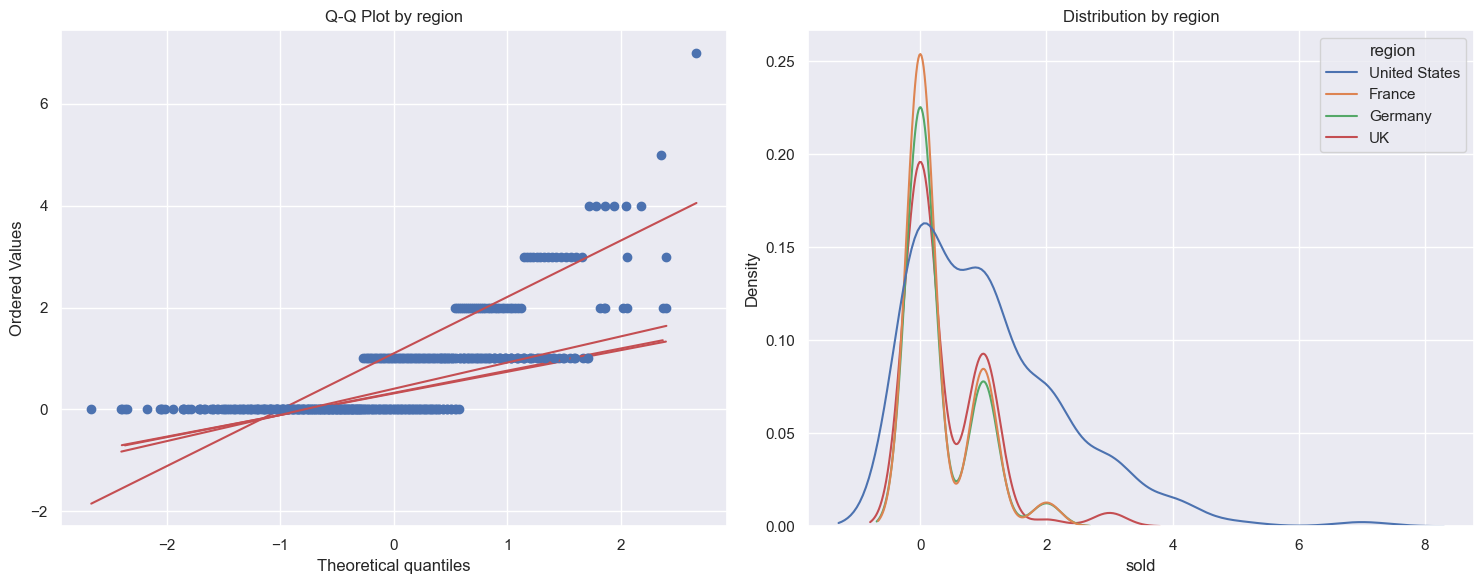

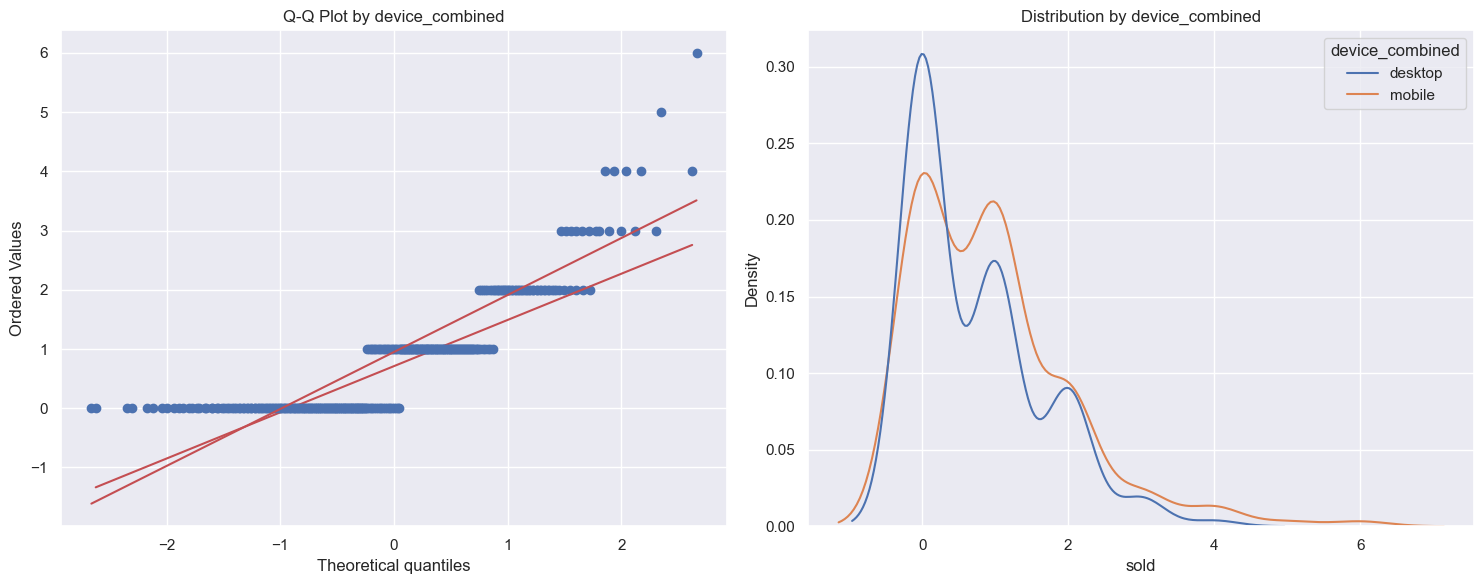

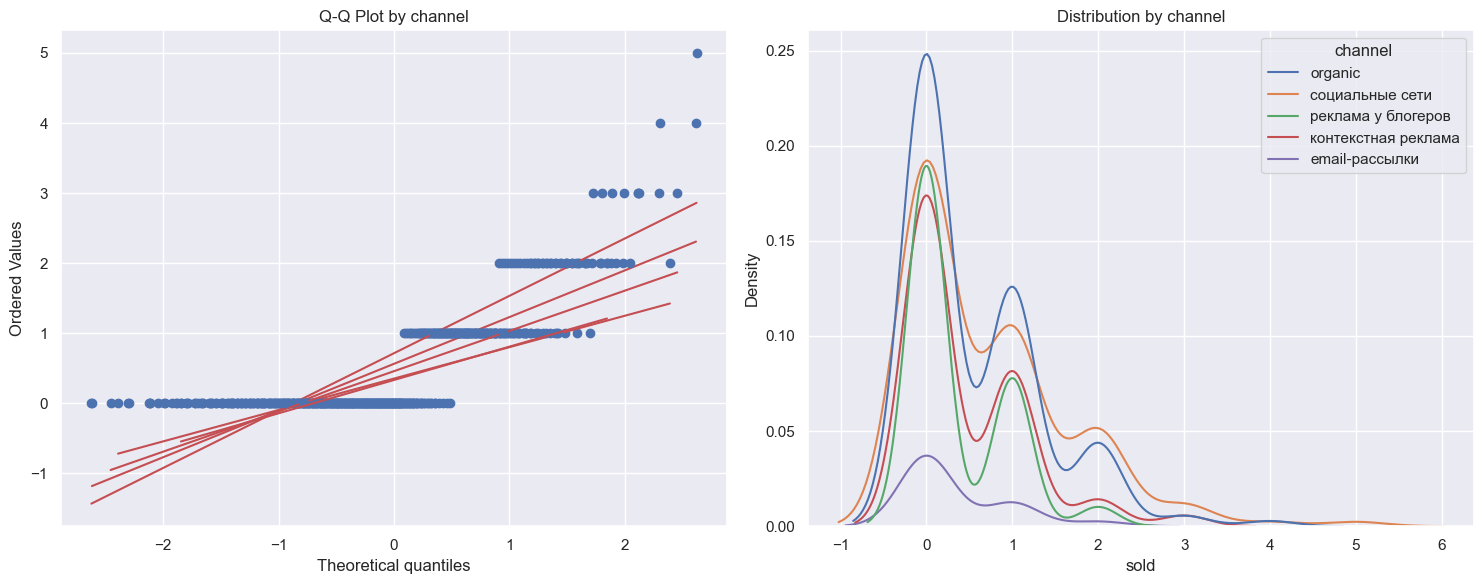

In [4]:
# Test region effect
region_effect = test_single_factor_effect(df, 'region')

# Test device effect with combining
device_effect = test_single_factor_effect(
    df, 
    'device',
    combine_groups={
        'iPhone': 'mobile',
        'Android': 'mobile',
        'Mac': 'desktop',
        'PC': 'desktop'
    }
)

# Test channel effect
channel_effect = test_single_factor_effect(df, 'channel')

In [5]:
region_effect

{'normality_results': {'United States': {'n_samples': 179,
   'shapiro_stat': np.float64(0.8138775932233177),
   'p_value': np.float64(7.663930244154419e-14),
   'normal': np.False_},
  'France': {'n_samples': 83,
   'shapiro_stat': np.float64(0.5983958216456784),
   'p_value': np.float64(1.0030746493485111e-13),
   'normal': np.False_},
  'Germany': {'n_samples': 77,
   'shapiro_stat': np.float64(0.6070613633491972),
   'p_value': np.float64(4.832716022285607e-13),
   'normal': np.False_},
  'UK': {'n_samples': 84,
   'shapiro_stat': np.float64(0.6240529734413813),
   'p_value': np.float64(2.4163832407061736e-13),
   'normal': np.False_}},
 'test_used': 'Kruskal-Wallis',
 'statistic': np.float64(55.669083871588015),
 'p_value': np.float64(4.942656018904422e-12),
 'significant': np.True_,
 'group_stats':                size      mean
 region                       
 France           83  0.313253
 Germany          77  0.324675
 UK               84  0.404762
 United States   179  1.100559

In [6]:
device_effect

{'normality_results': {'desktop': {'n_samples': 159,
   'shapiro_stat': np.float64(0.7661033105323091),
   'p_value': np.float64(1.2072798657731561e-14),
   'normal': np.False_},
  'mobile': {'n_samples': 178,
   'shapiro_stat': np.float64(0.7875044792193062),
   'p_value': np.float64(8.324735617836931e-15),
   'normal': np.False_}},
 'test_used': 'Mann-Whitney U',
 'statistic': np.float64(12435.5),
 'p_value': np.float64(0.03869906259333891),
 'significant': np.True_,
 'group_stats':                  size      mean
 device_combined                
 desktop           159  0.710692
 mobile            178  0.949438}

In [7]:
channel_effect

{'normality_results': {'organic': {'n_samples': 156,
   'shapiro_stat': np.float64(0.7154555155840439),
   'p_value': np.float64(4.998141638149883e-16),
   'normal': np.False_},
  'социальные сети': {'n_samples': 158,
   'shapiro_stat': np.float64(0.7469904562368979),
   'p_value': np.float64(3.347963701183472e-15),
   'normal': np.False_},
  'реклама у блогеров': {'n_samples': 82,
   'shapiro_stat': np.float64(0.6323186049648364),
   'p_value': np.float64(5.095804692284707e-13),
   'normal': np.False_},
  'контекстная реклама': {'n_samples': 98,
   'shapiro_stat': np.float64(0.6703792845222607),
   'p_value': np.float64(1.6260504629026077e-13),
   'normal': np.False_},
  'email-рассылки': {'n_samples': 21,
   'shapiro_stat': np.float64(0.6181014482765503),
   'p_value': np.float64(3.07733006234825e-06),
   'normal': np.False_}},
 'test_used': 'Kruskal-Wallis',
 'statistic': np.float64(10.882838636618585),
 'p_value': np.float64(0.02791278611525698),
 'significant': np.True_,
 'group_s